# One IRKGL16 Integration 6-Body Solar System  

<ul id="top">
    <li><a href="#Loading-packages-and-functions">Loading packages and functions</a></li>
    <li><a href="#Definition-of-the-N-body-problem">Definition of the N-body problem</a></li>
    <li><a href="#Integrations">Integrations</a></li>
    <li><a href="#Summary">Summary</a></li>
    <li><a href="#Errors-in-energy">Errors in energy</a></li>
    <li><a href="#Errors-in-position">Errors in position</a></li>
</ul>

## Loading packages and functions

In [1]:
using LinearAlgebra
using Plots

PATH_IRKGL="../../../../IRKGaussLegendre.jl-master/IRKGaussLegendre.jl-master/"
include(string(PATH_IRKGL,"src/IRKGaussLegendre.jl"))
using .IRKGaussLegendre  ## bertsio lokala exekutatzeko  

##### <a href="#top">Back to the top</a>

## Definition of the N-body problem

In Nbody.jl below, the following functions are defined: NbodyEnergy(u,Gm), NbodyODE!(du,u,Gm,t), and NbodyODE1!(du,u,Gm,t), where

\begin{equation*}
u = 
\left(\begin{matrix}
q_1  & v_1\\
\vdots & \vdots \\
q_N  & v_N
\end{matrix}
\right) \in \mathbb{R}^{2 \times 3\times N}, \quad
Gm = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N.
\end{equation*}

The energy, as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
\end{equation*}


The ODE system of the N-body problem,
as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split}
\end{equation*}
This system of ODEs can be writen in compact form as
\begin{equation*}
\frac{d u}{dt} = f(t,u,Gm)
\end{equation*}




In [2]:
PATH_ODES=string(PATH_IRKGL,"ODEProblems/")

include(string(PATH_ODES,"Initial6Body.jl"))
include(string(PATH_ODES,"Nbody.jl"))
include(string(PATH_ODES,"Nbody2nd.jl"))
include(string(PATH_ODES,"NbodyDyn.jl"));

### Initial value problem: 6-body problem (outer solar system)

We consider $N=6$ bodies of the outer solar system: the Sun, Jupiter, Saturn, Uranus, Neptune and Pluto.
The initial values $u_{00}$ are taken from DE430, Julian day (TDB) 2440400.5 (June 28, 1969). 

In [3]:
u0, Gm, bodylist = Initial6Body(Float64)
#u0_B, Gm_B, bodylist = Initial6Body(BigFloat)
u0_B=BigFloat.(u0)
Gm_B=BigFloat.(Gm)

q0=u0[:,:,1]
v0=u0[:,:,2]

N = length(Gm)

show(bodylist)
E0=NbodyEnergy(u0,Gm)

["Sun" "Jupiter" "Saturn" "Uranus" "Neptune" "Pluto"]

-9.522620605966966e-12

In [4]:
# Testing: center of mass of the outer solar system at the origin of coordinates with zero velocity

q0_ = zeros(3)
v0_ = zeros(3)
Gm0_ = 0.
for i in 1:6
    Gmi = Gm[i]
    qi = u0[:,i,1]
    vi = u0[:,i,2]
    q0_ += Gmi*qi
    v0_ += Gmi*vi
    Gm0_ += Gmi
end
(q0_/Gm0_, v0_/Gm0_)

([1.417048569677335e-18, 9.119357686204585e-20, 1.5082339679877506e-19], [1.0942040830907497e-22, -2.709864045560887e-22, 1.6237832716049163e-22])

In [5]:
t0=0.
tF=1e7   #1e9  # days

tspan= (t0,tF)
tspan_B=(BigFloat(t0),BigFloat(tF))

prob = ODEProblem(NbodyODE!, u0,tspan , Gm)
probDyn= DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0,v0,tspan,Gm)
prob2nd = SecondOrderODEProblem(NbodyODE2nd!,v0,q0,(t0,tF),Gm)
prob_B = ODEProblem(NbodyODE!, u0_B, tspan_B, Gm_B);

In [6]:
Jupiter_period = 11.9*365
tF/Jupiter_period

2302.290779325429

In [7]:
year=365.25
tF/year

27378.507871321013

##### <a href="#top">Back to the top</a>

## Integration

### IRKNGL 

In [8]:
dt0=100
#m0=4*5000
m0 = max(1,div(Int64(ceil((tF-t0)/dt0)),1000))
saveat=m0*dt0

println("dt = $dt0, steps=$((tF-t0)/dt0), m=$m0, n=$(tF/saveat)")

alg=IRKGL16(simd=true, second_order_ode=true, mstep=m0)
sol=solve(prob,alg,dt=dt0,adaptive=false);

dt = 100, steps=100000.0, m=100, n=1000.0


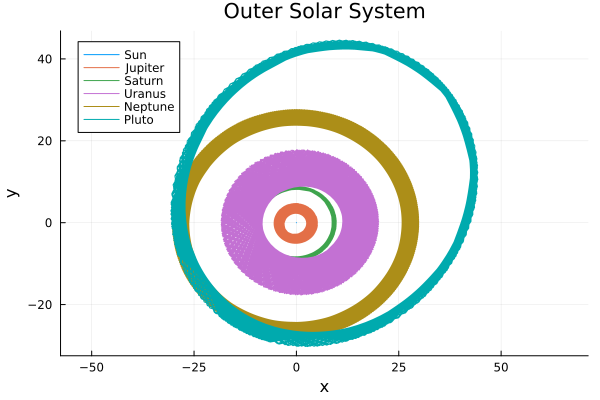

In [9]:
pl = plot(title="Outer Solar System", 
            xlabel="x", ylabel="y",  aspect_ratio=1)

for j = 1:6
    x  = [u[1,j,1] for u in sol.u]
    y  = [u[2,j,1] for u in sol.u] 
    pl = plot!(x,y, label=bodylist[j]) 
end 
display(pl)

### IRKNGL (exact solution)

In [10]:
dt1=dt0/2
m1=2*m0
saveat=m1*dt1

println("dt = $dt1, steps=$((tF-t0)/dt1), m=$m1, n=$(tF/saveat)")
alg=IRKGL16(simd=true, second_order_ode=true, mstep=m1)

@time sol1=solve(prob,alg,dt=dt1,adaptive=false);

dt = 50.0, steps=200000.0, m=200, n=1000.0
  0.837986 seconds (545.76 k allocations: 87.360 MiB, 2.17% gc time, 50.10% compilation time)


In [11]:
[sol1.t[1:10] sol.t[1:10] sol1.t[end-9:end] sol.t[end-9:end]]

10×4 Matrix{Float64}:
     0.0      0.0  9.91e6  9.91e6
 10000.0  10000.0  9.92e6  9.92e6
 20000.0  20000.0  9.93e6  9.93e6
 30000.0  30000.0  9.94e6  9.94e6
 40000.0  40000.0  9.95e6  9.95e6
 50000.0  50000.0  9.96e6  9.96e6
 60000.0  60000.0  9.97e6  9.97e6
 70000.0  70000.0  9.98e6  9.98e6
 80000.0  80000.0  9.99e6  9.99e6
 90000.0  90000.0  1.0e7   1.0e7

<a href="#top">Back to the top</a>

## Errors in energy

In [12]:
function ErrorEnergy(H0, Ham, sol, parms_B)

    H = [Ham(BigFloat.(u),parms_B) for u in sol.u]
    ΔH0 = @. Float64(abs(H/H0-1))
    H_lerr = @. Float64(abs((H[2:end] / H[1:end-1]) - 1))
   
    return ΔH0, H_lerr

end

ErrorEnergy (generic function with 1 method)

In [13]:
u0_B = BigFloat.(u0)
Gm_B = BigFloat.(Gm)
H0=NbodyEnergy(u0_B,Gm_B)

ΔH0, H_lerr=ErrorEnergy(H0, NbodyEnergy, sol, Gm_B)
ΔH0_1, H_lerr_1=ErrorEnergy(H0, NbodyEnergy, sol1, Gm_B)
(maximum(ΔH0), maximum(H_lerr), maximum(ΔH0_1), maximum(H_lerr_1))

(1.1436233035725609e-14, 6.1352006463913e-16, 3.553013588250212e-15, 5.217514423117023e-16)

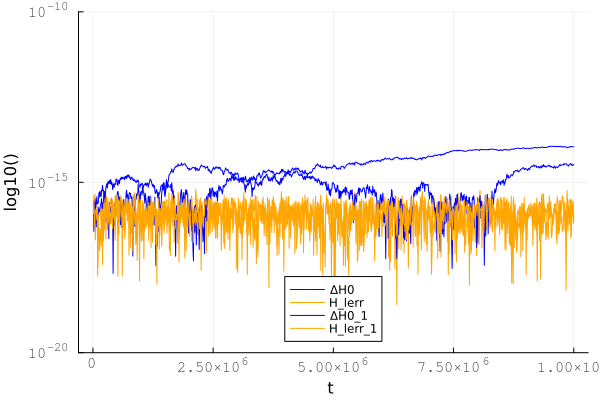

In [14]:
yrange=(1e-20,1e-10)
plot(title="",xlabel="t ", ylabel="log10()", 
     yscale=:log10, ylims=yrange,
     xtickfont = font(8, "Courier"),
     ytickfont = font(8, "Courier"),
     legend=:bottom)
plot!(sol.t,abs.(ΔH0),label="ΔH0", color="blue")
plot!(sol.t[2:end],abs.(H_lerr),label="H_lerr", color="orange")
plot!(sol.t,abs.(ΔH0_1),label="ΔH0_1", color="blue")
plot!(sol.t[2:end],abs.(H_lerr_1),label="H_lerr_1", color="orange")

<a href="#top">Back to the top</a>

## Errors in position

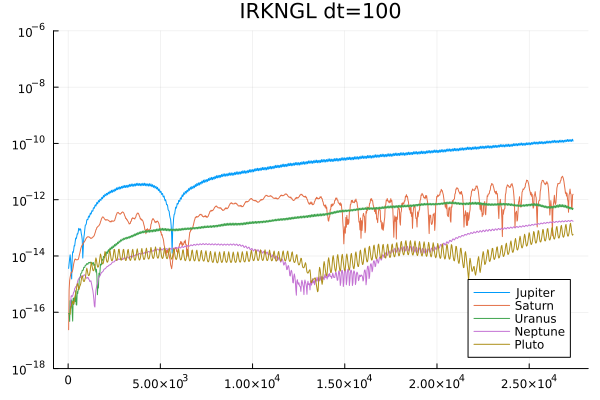

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/utils.jl:106


In [15]:
error_q=Array{Array{Float64,1}}(undef,N)

for i in 1:N
    error_q[i]=map((u0,u1)-> (BigFloat(norm(u0[:,i,1]-u1[:,i,1])/norm(u0[:,i,1]))), sol.u[2:end],sol1.u[2:end])
end

planets= ["Jupiter" "Saturn" "Uranus"  "Neptune" "Pluto"]
yrange=(1e-18, 1e-6)

pl1=plot(sol.t[2:end]/year, error_q[2:end],
         title="IRKNGL dt=$dt0",
         ylims=yrange,
         yscale=:log10,
         xlabel="",
         ylabel="",
         label=planets,legend=:bottomright)